In [1]:
#Подключим библиотеки

import numpy as np
import pandas as pd
import pickle
import catboost as catb

 
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 


In [4]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [7]:

# Тренеровочный
TRAIN_DATASET_PATH = 'F:/Lesson/course_project_train.csv'
TRAIN_PREP_DATASET_TEST = 'F:/Lesson/course_project_train_prep.csv'

# Тестовый
TEST_DATASET_PATH = 'F:/Lesson/course_project_test.csv'
TEST_PREP_DATASET_PATH = 'F:/Lesson/course_project_test_prep.csv'

MODEL_FILE_PATH = 'F:/Lesson/MGluhovtsev_predictons.csv'

In [8]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [9]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [10]:
### подготовка данных

In [11]:
# берем среднее значение для NaN значений в 'Annual Income'
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace=True)
df_test['Annual Income'].fillna(df_test['Annual Income'].median(), inplace=True)

# Приравниваем значения NaN к нулю, и делим все значения в столбце 'Months since last delinquent' на 100
# таким образом все значения в стольбце распределяются по возрастающей стремящеся к нулю.
df_train.fillna(0, inplace=True)
df_train['Months since last delinquent'] = df_train['Months since last delinquent']/100
df_test.fillna(0, inplace=True)
df_test['Months since last delinquent'] = df_test['Months since last delinquent']/100

# приводим обьекты к цифровым значениям
le = LabelEncoder()
df_train['Home Ownership'] = le.fit_transform(df_train['Home Ownership'])
df_test['Home Ownership'] = le.transform(df_test['Home Ownership'])

df_train['Purpose'] = le.fit_transform(df_train['Purpose'])
df_test['Purpose'] = le.transform(df_test['Purpose'])

df_train['Term'] = le.fit_transform(df_train['Term'])
df_test['Term'] = le.transform(df_test['Term'])

# Заменить значения на цифры
replace_dict = {'< 1 year':0,'1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':10}

df_train['Years in current job'].replace(replace_dict, inplace=True)
df_test['Years in current job'].replace(replace_dict, inplace=True)
df_train['Years in current job'].astype(int)
df_test['Years in current job'].astype(int)



0        4
1        1
2        3
3       10
4        6
        ..
2495    10
2496     2
2497     2
2498    10
2499    10
Name: Years in current job, Length: 2500, dtype: int32

In [12]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,2,482087.0,0,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,3,1,99999999.0,47386.0,7914.0,749.0,0
1,2,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,3,0,264968.0,394972.0,18373.0,737.0,1
2,1,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,3,1,99999999.0,308389.0,13651.0,742.0,0
3,2,805068.0,6,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,3,1,121396.0,95855.0,11338.0,694.0,0
4,3,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,3,1,125840.0,93309.0,7180.0,719.0,0


In [13]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,3,1178475.0,4,0.0,9.0,12.5,220968.0,0.0,0.70,0.0,3,1,162470.0,105906.0,6813.0,0.0
1,3,231838.0,1,0.0,6.0,32.7,55946.0,0.0,0.08,0.0,4,1,78298.0,46037.0,2318.0,699.0
2,1,1152540.0,3,0.0,10.0,13.7,204600.0,0.0,0.00,0.0,3,1,200178.0,146490.0,18729.0,7260.0
3,1,1220313.0,10,0.0,16.0,17.0,456302.0,0.0,0.70,0.0,3,1,217382.0,213199.0,27559.0,739.0
4,1,2340952.0,6,0.0,11.0,23.6,1207272.0,0.0,0.00,0.0,3,0,777634.0,425391.0,42605.0,706.0


In [14]:
df_train.shape

(7500, 17)

In [15]:
df_test.shape

(2500, 16)

In [16]:
df_train.iloc[0]

Home Ownership                         2.0
Annual Income                     482087.0
Years in current job                   0.0
Tax Liens                              0.0
Number of Open Accounts               11.0
Years of Credit History               26.3
Maximum Open Credit               685960.0
Number of Credit Problems              1.0
Months since last delinquent           0.0
Bankruptcies                           1.0
Purpose                                3.0
Term                                   1.0
Current Loan Amount             99999999.0
Current Credit Balance             47386.0
Monthly Debt                        7914.0
Credit Score                         749.0
Credit Default                         0.0
Name: 0, dtype: float64

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int32  
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int64  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   int32  
 11  Term                          7500 non-null   int32  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [18]:
#Удаляем малозначимые столбцы и определяем целевую переменную

In [19]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME, 'Tax Liens', 'Bankruptcies']).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()
#Категориальные значения
CAT_FEATURE_NAMES = ['Home Ownership','Years in current job','Purpose', 'Term',]

In [20]:
#Подготавливаем тренеровочный датасет для обучения.Разбиваем тренировочный и тестовый.

In [21]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [22]:
#Балансруем данные

In [23]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [24]:
y_test.head()

124     0
4041    0
2588    0
3566    0
2660    1
Name: Credit Default, dtype: int64

In [25]:
#Обучаем модель на тренировочном датасете

In [26]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train, cat_features=CAT_FEATURE_NAMES)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      4047
           1       0.79      0.63      0.70      3156

    accuracy                           0.76      7203
   macro avg       0.77      0.75      0.75      7203
weighted avg       0.76      0.76      0.76      7203

TEST

              precision    recall  f1-score   support

           0       0.82      0.84      0.82      1340
           1       0.56      0.53      0.54       535

    accuracy                           0.75      1875
   macro avg       0.69      0.68      0.68      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1119  221
1                254  281


In [ ]:
#График для подбора сбалансированных параметров

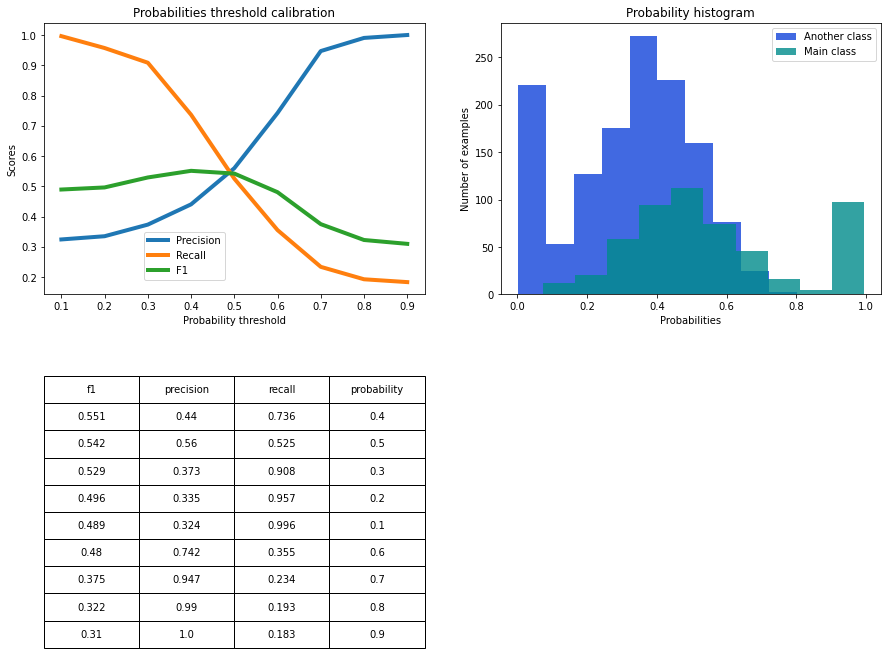

In [27]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [ ]:
#Определение лишних данных и отделение их

F:\program\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


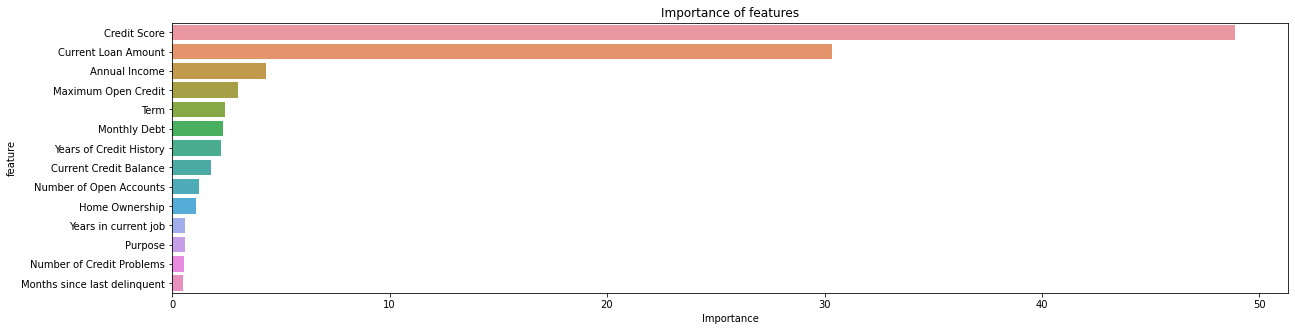

In [28]:
important_features_top = show_feature_importances(X_train.columns, 
                                                  final_model.feature_importances_, get_top=5)

In [29]:
#Удаление малоэфективных значений

NEW_FEATURE_NAMES_test = df_test.columns.drop(['Tax Liens', 'Bankruptcies']).tolist()

X_test = df_test[NEW_FEATURE_NAMES_test]
#Использование модели на данных для предсказания
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)


In [30]:
#Создаем базу заполняем предсказанными значениями
submit = pd.DataFrame()

submit['Credit Default'] = y_test_pred


In [31]:
submit

,Credit Default
0,0
1,1
2,1
3,0
4,0
...,...
2495,0
2496,0
2497,0
2498,0


In [ ]:
#Сохраняем в файл полученные результаты

In [32]:
submit.to_csv('F:/Lesson/MGluhovtsev_predictons.csv')